# Kernel Trick Models


In [1]:
import os
from sys import stdout
import time

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import scipy.io
from sklearn import model_selection
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet,ElasticNetCV
from deap import base
from deap import creator
from deap import tools

from feature_selection import *



import warnings
warnings.filterwarnings('ignore')

In [2]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return msemin+1
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [3]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [4]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [5]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [6]:
def genetic_algorithm(X, y):

    autoscaled_X_train= X
    autoscaled_y_train=y



    # GAPLS
    creator.create('FitnessMax', base.Fitness, weights=(1.0,))  # for minimization, set weights as (-1.0,)
    creator.create('Individual', list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    min_boundary = np.zeros(X_train.shape[1])
    max_boundary = np.ones(X_train.shape[1]) * 1.0
    #print(min_boundary.shape)
    #print(max_boundary.shape)


    ###this one is for selecting at random the "individual"
    def create_ind_uniform(min_boundary, max_boundary):
        index = []
        for min, max in zip(min_boundary, max_boundary):
            index.append(random.uniform(min, max))
        return index


    toolbox.register('create_ind', create_ind_uniform, min_boundary, max_boundary)
    toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.create_ind)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)


    def evalOneMax(individual):
        individual_array = np.array(individual)
        #individual array is an array of lenght "wl" with values between 0 and 1. 
        #print("individual_array", individual_array.shape)

        selected_X_variable_numbers = np.where(individual_array > threshold_of_variable_selection)[0]
        #If an element of ind_arr is bigger than thresh it is kept. this one will be used for the selection of selected_autoscaled_X_train
        #print("selected_X_variable_numbers: ", selected_X_variable_numbers.shape)

        selected_autoscaled_X_train = autoscaled_X_train[:, selected_X_variable_numbers]
        #print("selected_autoscaled_X_train: ", selected_autoscaled_X_train.shape)


        if len(selected_X_variable_numbers):
            # cross-validation
            #print("np.linalg.matrix_rank(selected_autoscaled_X_train)", np.linalg.matrix_rank(selected_autoscaled_X_train))

            #print("AAAA ", min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1, max_number_of_components + 1))

            pls_components = np.arange(1, min(min(selected_autoscaled_X_train.shape[0],selected_autoscaled_X_train.shape[1]) + 1,
                                              max_number_of_components + 1), 1)
            #pls_components = np.arange(1, min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1,
            #                                  max_number_of_components + 1), 1)
            #print("pls components: ", pls_components)

            r2_cv_all = []

            for pls_component in pls_components:

                model_in_cv = PLSRegression(n_components=pls_component)

                #print("selected_autoscaled_X_train",selected_autoscaled_X_train)

                estimated_y_train_in_cv = np.ndarray.flatten(
                    model_selection.cross_val_predict(model_in_cv, selected_autoscaled_X_train, autoscaled_y_train, cv=fold_number))



                estimated_y_train_in_cv = estimated_y_train_in_cv * y_train.std(ddof=1) + y_train.mean()
                r2_cv_all.append(1 - sum((y_train - estimated_y_train_in_cv) ** 2) / sum((y_train - y_train.mean()) ** 2))
            #print(len(r2_cv_all))
            #print("r2_cv_all: ",r2_cv_all)
            """
            try:
                value = np.max(r2_cv_all)
            except ValueError:  #raised if `y` is empty.
                value = -999
                pass
            """
            value = np.max(r2_cv_all)

        else:
            value = -999

        return value,


    toolbox.register('evaluate', evalOneMax)
    toolbox.register('mate', tools.cxTwoPoint)
    toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
    toolbox.register('select', tools.selTournament, tournsize=3)

    # random.seed(100)
    random.seed()
    pop = toolbox.population(n=number_of_population)

    print('Start of evolution')

    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    print('  Evaluated %i individuals' % len(pop))

    for generation in range(number_of_generation):
        print('-- Generation {0} --'.format(generation + 1))

        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < probability_of_crossover:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < probability_of_mutation:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        print('  Evaluated %i individuals' % len(invalid_ind))

        pop[:] = offspring
        fits = [ind.fitness.values[0] for ind in pop]

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x * x for x in fits)
        std = abs(sum2 / length - mean ** 2) ** 0.5

        print('  Min %s' % min(fits))
        print('  Max %s' % max(fits))
        print('  Avg %s' % mean)
        print('  Std %s' % std)

    print('-- End of (successful) evolution --')

    best_individual = tools.selBest(pop, 1)[0]
    best_individual_array = np.array(best_individual)
    selected_X_variable_numbers = np.where(best_individual_array > threshold_of_variable_selection)[0]
    print('Selected variables : %s, %s' % (selected_X_variable_numbers, best_individual.fitness.values))

In [7]:
def optimise_pca_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    
    pca = PCA()
    Xstd = StandardScaler().fit_transform(X)
    
    for i in component:
        
        Xreg = pca.fit_transform(Xstd)[:,: i]
        
        regr = linear_model.LinearRegression()
        # Fit
        regr.fit(Xreg, y)
        
        y_cv = cross_val_predict(regr, Xreg, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PCR components')
            plt.ylabel('MSE')
            plt.title('PCR')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    """
    pcr_opt = PCR(n_components=msemin+1)
    
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    """
    return msemin+1

In [8]:
def _calculate_vips(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
    return vips

In [9]:
"""# Define the PLS regression object
pls = PLSRegression(n_components=8)
# Fit data
pls.fit(X_train, y_train)
# Plot spectra
plt.figure(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wl, X_train.T)
    plt.ylabel('First derivative absorbance spectra')
    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wl, np.abs(pls.coef_[:,0])) ###this is the interesting line!!!
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absolute value of PLS coefficients')
    plt.show()
"""

"# Define the PLS regression object\npls = PLSRegression(n_components=8)\n# Fit data\npls.fit(X_train, y_train)\n# Plot spectra\nplt.figure(figsize=(8,9))\nwith plt.style.context(('ggplot')):\n    ax1 = plt.subplot(211)\n    plt.plot(wl, X_train.T)\n    plt.ylabel('First derivative absorbance spectra')\n    ax2 = plt.subplot(212, sharex=ax1)\n    plt.plot(wl, np.abs(pls.coef_[:,0])) ###this is the interesting line!!!\n    plt.xlabel('Wavelength (nm)')\n    plt.ylabel('Absolute value of PLS coefficients')\n    plt.show()\n"

In [10]:
def linear_pca(X, gamma, n_components):
    # Calculating kernel

    K = gamma*(X@X.T+1)


    # Obtaining eigenvalues in descending order with corresponding
    # eigenvectors from the symmetric matrix.
    eigvals, eigvecs = eigh(K)

    # Obtaining the i eigenvectors that corresponds to the i highest eigenvalues.
    X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))

    return X_pc

In [11]:
def degree_pca(X, gamma, degree, n_components):
    # Calculating kernel

    K = gamma*(X@X.T+1)**degree


    # Obtaining eigenvalues in descending order with corresponding
    # eigenvectors from the symmetric matrix.
    eigvals, eigvecs = eigh(K)

    # Obtaining the i eigenvectors that corresponds to the i highest eigenvalues.
    X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))

    return X_pc

In [12]:
def stepwise_kpca(X, gamma, n_components):
    """
    X: A MxN dataset as NumPy array where the samples are stored as rows (M), features as columns (N).
    gamma: coefficient for the RBF kernel.
    n_components: number of components to be returned.

    """
    # Calculating the squared Euclidean distances for every pair of points
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Converting the pairwise distances into a symmetric MxM matrix.
    mat_sq_dists = squareform(sq_dists)

    K=np.exp(-gamma*mat_sq_dists)

    # Centering the symmetric NxN kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenvalues in descending order with corresponding
    # eigenvectors from the symmetric matrix.
    eigvals, eigvecs = eigh(K)

    # Obtaining the i eigenvectors that corresponds to the i highest eigenvalues.
    X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))

    return X_pc

# Data loading

In [13]:
x_df = pd.read_csv('./avg_basic_noPure.csv', sep = ',')
#x_df = pd.read_csv('./avg_snv_noPure.csv', sep = ',')
#x_df = pd.read_csv('./avg_norm_noPure.csv', sep = ',')
#x_df = pd.read_csv('./avg_sum_noPure.csv', sep = ',')
#x_df = pd.read_csv('./avg_max_noPure.csv', sep = ',')





x_df= x_df.drop(columns=['Measurement'])

x_df= x_df.drop([3, 9, 15, 20])
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(27, 4094)
(4094,)
27


,188.195100,188.260100,188.325000,188.390000,188.455000,188.520000,188.585000,188.650000,188.714900,188.779900,...,440.300000,440.353000,440.406100,440.459200,440.512300,440.565300,440.618400,440.671400,440.724500,440.777500
0,-69.221869,-158.742833,-119.436366,-188.904643,-63.993252,-185.913809,-68.912441,-71.982774,-49.260124,-111.210412,...,57.987736,-58.837784,60.078744,-58.499735,50.963564,9.325138,48.628583,-25.978052,56.219128,-49.945180
1,-65.918565,-155.629829,-115.410786,-188.773574,-61.814280,-183.332260,-63.567206,-67.330086,-45.602930,-110.031973,...,57.015086,-44.614609,81.401937,-24.462199,86.909142,29.507515,56.597968,-23.360151,54.799998,-51.003948
2,-66.099613,-157.373422,-117.842186,-186.255659,-62.889293,-184.760538,-69.228256,-72.855963,-50.517550,-109.723183,...,51.295238,-38.257145,99.672488,7.856212,126.134965,58.828834,86.152177,28.781044,130.722225,34.606180
4,-42.057358,-128.338506,-92.421250,-157.127160,-38.871675,-168.524296,-64.353986,-71.829442,-49.694992,-97.063802,...,65.735997,-15.182984,124.486568,38.564898,161.342291,74.535128,69.869111,-21.924734,55.972500,-55.878599
5,-42.559352,-128.806762,-93.862528,-160.944227,-40.074908,-167.939000,-62.026407,-67.816945,-46.463337,-97.883434,...,49.860573,-54.591599,67.895710,-44.346086,70.806932,15.151596,42.458800,-37.899700,43.898862,-65.108049
6,-46.600930,-131.936044,-96.007751,-163.920148,-40.905090,-172.729129,-64.568914,-70.719383,-50.106389,-98.386069,...,64.836896,-1.400873,148.828206,76.637705,211.221637,103.942782,89.391051,4.976541,89.927960,-13.085920
7,-44.351517,-128.386838,-94.080659,-159.433718,-39.895899,-169.744105,-65.728141,-72.196175,-51.243962,-97.024420,...,55.908894,-52.221276,68.591386,-42.618967,68.689610,19.444365,48.518350,-30.592518,51.197878,-59.143871
8,-42.553121,-129.333489,-93.232050,-157.068189,-39.735661,-170.282264,-66.426450,-72.554660,-52.577903,-97.059243,...,56.146984,-50.209511,74.266658,-35.492235,74.451395,23.316674,49.373189,-30.672551,51.549971,-62.015022
10,-46.367951,-133.721168,-96.179816,-163.553262,-43.700926,-171.866675,-64.559553,-71.527150,-50.012263,-99.064929,...,47.518467,-64.467707,56.326725,-54.994930,59.984792,15.053969,49.179587,-19.511623,68.100683,-32.760920
11,-43.524640,-130.848225,-96.193804,-160.092164,-41.326292,-170.412308,-65.282753,-72.170753,-50.730253,-98.384991,...,53.111790,-62.522253,56.037251,-61.590929,46.987634,6.107255,44.191685,-29.728281,57.196328,-53.294018


[[188.1951]
 [188.2601]
 [188.325 ]
 ...
 [440.6714]
 [440.7245]
 [440.7775]]
wl shape:  (4094, 1)


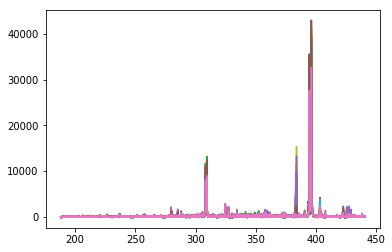

In [14]:
#This is just for visualizing the various plots of the samples


mat = scipy.io.loadmat("./data/002_29-Granges6958-v-335_200Hz_QS295_trig1435_int0.1.mat")
wl= mat["wl"]
print(wl)
print("wl shape: ", wl.shape)

for i in range(len(values)):
    plt.plot(wl, values[i])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""


In [15]:
print(wl[0])
print(wl[-1])

[188.1951]
[440.7775]


In [16]:
df_y = pd.read_csv('./al_concentration_noPure.csv')
df_y= df_y.drop([3, 9, 15, 20])
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,2:10])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(27, 14)


,Measurement,Reference material,Si,Fe,Mg,Ti,Ni,Zn,Cu,Mn,Pb,Sn,Cr,Al (100-summa)
0,1,Pech. 68451,0.070,0.100,0.4100,0.0400,0.0400,0.180,0.060,1.4500,0.0000,0.0000,0.0000,97.6
1,2,Gränges al 6958-v-335,0.180,0.350,2.0300,0.0600,0.0000,6.080,1.350,0.4500,0.0000,0.0000,0.1000,89.4
2,3,4343-AA,7.460,0.530,0.0360,0.0450,0.0310,0.140,0.150,0.1000,0.0000,0.0000,0.0000,91.4
4,10,Pech. 1206,3.000,0.795,0.5700,0.0930,0.3010,0.154,4.290,0.0370,0.1000,0.2000,0.0000,90.5
5,11,Gränges al 6958-v-331,0.120,0.300,3.0400,0.0290,0.0000,4.930,1.850,0.0600,0.0000,0.0000,0.4000,89.3
6,12,NIST 1255a,7.220,0.140,0.3600,0.1540,0.0180,0.084,0.120,0.0530,0.0000,0.0000,0.0000,91.8
7,14,NBS 1258,0.780,0.079,0.9800,0.0000,0.0010,1.030,0.840,0.4800,0.0000,0.0000,0.0000,95.8
8,15,O 2:3,6.160,0.000,0.3630,0.0080,0.0000,0.000,0.006,0.2060,0.0000,0.0000,0.0000,93.3
10,17,NBS 1241a,0.160,0.200,4.5400,0.0320,0.0200,0.052,0.050,0.3800,0.0000,0.0000,0.0000,94.5
11,18,J 2:3,6.120,0.000,0.3200,0.0030,0.0000,0.000,0.005,0.0160,0.0000,0.0000,0.0000,93.5


In [652]:
y_val = concentration[:,3] #2-Si, 3-Fe, 4-Mg, 7-Zn, 8-Cu, 9-Mn (7-Zn but too much sparse)
#print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
y_df.T

(27,)


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.1,0.35,0.53,0.795,0.3,0.14,0.079,0,0.2,0,...,0.31,0,0.31,1.19,0,0.228,1.01,0.18,0,0.865


In [16]:
#optimise_pls_cv(x_df, y_df, 20, plot_components=True) 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state = 2)
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

print(y_test)

#optimise_pls_cv(X_train, y_train, 17, plot_components=True) 

(21, 4094) (21, 1)
(6, 4094) (6, 1)
        0
25  0.339
0    0.41
9    0.32
20   0.39
16   2.48
12   1.71


## Kernel PCR - my version

R2_cv:  0.5926168804413563
RMSE_cv:  0.8219344153591142
R2_pred:  -3.647192602944904
RMSE_pred:  1.8235799658380951


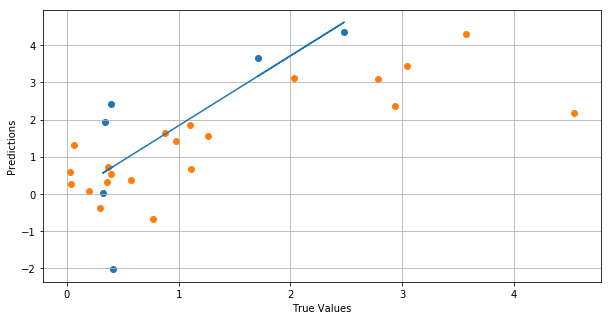

In [47]:
#standardize input
X_std = StandardScaler().fit_transform(X_train.values)
X_std_test = StandardScaler().fit_transform(X_test.values)

#select kernel type and attributes
X_pc =  linear_pca(X_std, gamma = 1, n_components= 6)
X_test_pc =  linear_pca(X_std_test, gamma = 1, n_components= 6)

X_pc =  degree_pca(X_std, gamma = 2, degree= 2, n_components= 6)
X_test_pc =  degree_pca(X_std_test, gamma = 2, degree= 2, n_components= 6)

X_pc =  stepwise_kpca(X_std, gamma = 0.000001,  n_components= 6)
X_test_pc =  stepwise_kpca(X_std_test, gamma = 0.000001, n_components= 6)


#create linear model
regr = linear_model.LinearRegression()
# Fit
regr.fit(X_pc, y_train)

# Cross-validation and prediction
y_cv = cross_val_predict(regr , X_pc, y_train, cv=10)
y_pred = regr.predict(X_test_pc)

# Calculate score and error
r2_cv = r2_score(y_train, y_cv)
r2_p = r2_score(y_test, y_pred)

rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_cv: ",r2_cv)
print("RMSE_cv: ", rmse_cv)
print("R2_pred: ", r2_p)
print("RMSE_pred: ", rmse)

plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_cv)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
#plt.savefig("../basic_PLS.png")
plt.grid(True)
plt.show()

In [942]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state = 1)

## Principal Components Regression

100% completed
Suggested number of components:  4



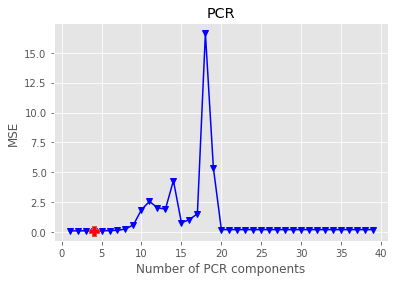

In [943]:
pca_comp = optimise_pca_cv(X_train, y_train, 40, plot_components=True) 

In [944]:
n_components= pca_comp
x = X_train.values
x_t = X_test.values


# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= min(X_train.shape[0], n_components))
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test_pc = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(21, 4)
[29.89 46.89 62.85 73.6 ]


0.09414260428768462
0.30735011809088425
0.57504732095328
0.17804657968858587


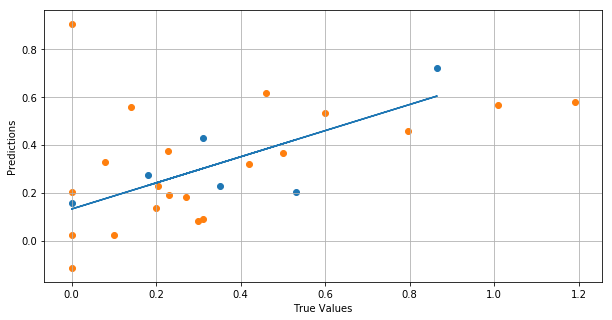

In [945]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)

# Cross-validation and prediction
y_cv = cross_val_predict(regr , x_pc, y_train, cv=10)
y_pred = regr.predict(x_test_pc)
y_c = regr.predict(x_pc)

# Calculate score and error
r2_cv = r2_score(y_train, y_cv)
r2_p = r2_score(y_test, y_pred)

rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
rmse = sqrt(mean_squared_error(y_test, y_pred))


"""
print("")
print("R2_cv: ",r2_cv)
print("RMSE_cv: ", rmse_cv)
print("R2_pred: ", r2_p)
print("RMSE_pred: ", rmse)
"""

print(r2_cv)
print(rmse_cv)
print(r2_p)
print(rmse)

plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_cv)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
#plt.savefig("../basic_PCR.png")
plt.grid(True)
plt.show()

## Kernel PCR

In [946]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)

X_std = StandardScaler().fit_transform(X_train.values)
X_std_test = StandardScaler().fit_transform(X_test.values)

### Linear kernel

-0.9471029471132015
0.4506069897813456
0.8050919093038154
0.1205808339140723


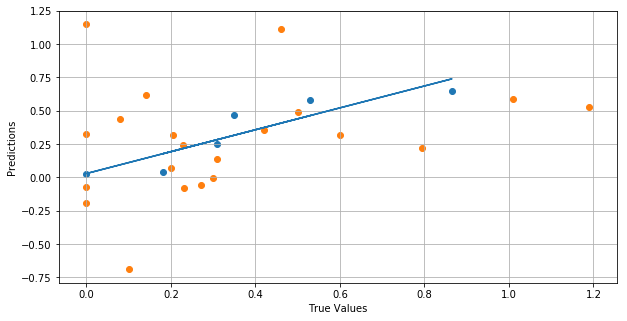

In [947]:
kerPCA = KernelPCA(n_components=20, kernel='linear')

x_kpc = kerPCA.fit_transform(X_std)
x_test_kpc = kerPCA.transform(X_std_test)
#print(x_kpc.shape)

regr = linear_model.LinearRegression()
# Fit
regr.fit(x_kpc, y_train)

# Cross-validation and prediction
y_cv = cross_val_predict(regr , x_kpc, y_train, cv=10)
y_pred = regr.predict(x_test_kpc)
y_c = regr.predict(x_kpc)

# Calculate score and error
r2_cv = r2_score(y_train, y_cv)
r2_p = r2_score(y_test, y_pred)

rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
rmse = sqrt(mean_squared_error(y_test, y_pred))


"""
print("")
print("R2_cv: ",r2_cv)
print("RMSE_cv: ", rmse_cv)
print("R2_pred: ", r2_p)
print("RMSE_pred: ", rmse)
"""

print(r2_cv)
print(rmse_cv)
print(r2_p)
print(rmse)


plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_cv)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

### Polynomial kernel


-0.45249785346769844
0.3891895913073234
0.7831335103633
0.1271919349711729


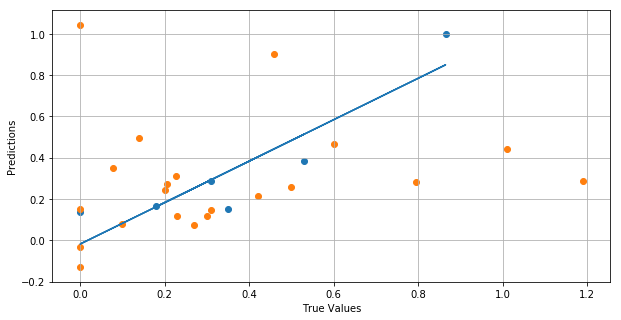

In [948]:
kerPCA = KernelPCA(n_components=20, kernel='poly', degree=2, coef0=1)

x_kpc = kerPCA.fit_transform(X_std)
x_test_kpc = kerPCA.transform(X_std_test)
#print(x_kpc.shape)

regr = linear_model.LinearRegression()
# Fit
regr.fit(x_kpc, y_train)

# Cross-validation and prediction
y_cv = cross_val_predict(regr , x_kpc, y_train, cv=10)
y_pred = regr.predict(x_test_kpc)
y_c = regr.predict(x_kpc)

# Calculate score and error
r2_cv = r2_score(y_train, y_cv)
r2_p = r2_score(y_test, y_pred)

rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
rmse = sqrt(mean_squared_error(y_test, y_pred))

"""
print("")
print("R2_cv: ",r2_cv)
print("RMSE_cv: ", rmse_cv)
print("R2_pred: ", r2_p)
print("RMSE_pred: ", rmse)
"""
print("")
print(r2_cv)
print(rmse_cv)
print(r2_p)
print(rmse)


plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_cv)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

### Gaussian kernel


-0.4822838721480105
0.3931598482694178
0.8438983061635859
0.10791135782823945


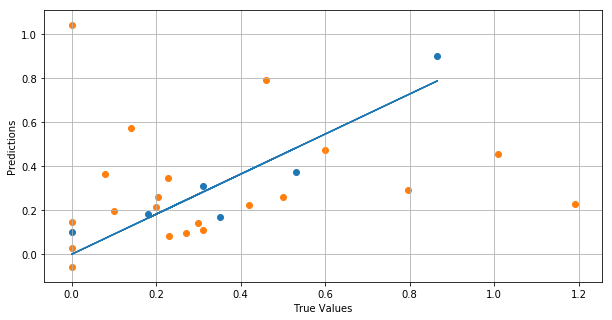

In [949]:
kerPCA = KernelPCA(n_components=20, kernel='rbf', gamma=0.0001)

x_kpc = kerPCA.fit_transform(X_std)
x_test_kpc = kerPCA.transform(X_std_test)
#print(x_kpc.shape)

regr = linear_model.LinearRegression()
# Fit
regr.fit(x_kpc, y_train)

# Cross-validation and prediction
y_cv = cross_val_predict(regr , x_kpc, y_train, cv=10)
y_pred = regr.predict(x_test_kpc)
y_c = regr.predict(x_kpc)

# Calculate score and error
r2_cv = r2_score(y_train, y_cv)
r2_p = r2_score(y_test, y_pred)

rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
rmse = sqrt(mean_squared_error(y_test, y_pred))

"""
print("")
print("R2_cv: ",r2_cv)
print("RMSE_cv: ", rmse_cv)
print("R2_pred: ", r2_p)
print("RMSE_pred: ", rmse)
"""
print("")
print(r2_cv)
print(rmse_cv)
print(r2_p)
print(rmse)


plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_cv)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Partial Least Squares

100% completed
Suggested number of components:  1



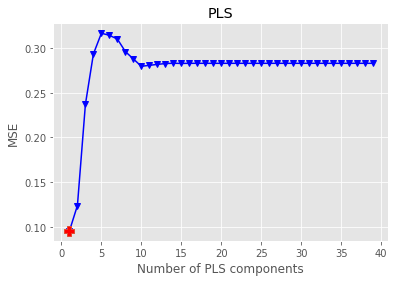

R2 calib: 0.495
R2 CV: 0.085
MSE calib: 0.053
MSE CV: 0.095


In [950]:
plscomp = optimise_pls_cv(X_train, y_train, 40, plot_components=True) 

-2.0136364434612566
0.5605945827284529
0.11869885305183425
0.2564044256994739


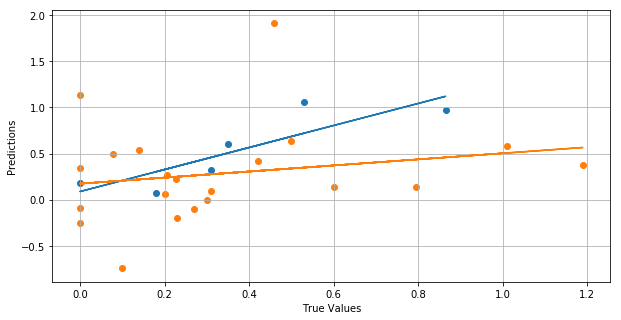

In [951]:
# Define PLS object

pls =  PLSRegression(n_components=max(6,plscomp), scale=True)
#pls =  PLSRegression(n_components=20)

# Fit
pls.fit(X_train, y_train)
y_c = pls.predict(X_train)

y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
y_pred = pls.predict(X_test)


# Calculate score and error
r2_cv = r2_score(y_train, y_cv)
r2_p = r2_score(y_test, y_pred)

rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
rmse = sqrt(mean_squared_error(y_test, y_pred))


"""
print("")
print("R2_cv: ",r2_cv)
print("RMSE_cv: ", rmse_cv)
print("R2_pred: ", r2_p)
print("RMSE_pred: ", rmse)
"""

print(r2_cv)
print(rmse_cv)
print(r2_p)
print(rmse)

c=np.append(y_train, y_cv, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_cv)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.plot( y_train, linear_model.LinearRegression().fit(y_train, y_cv).predict(y_train) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
#plt.savefig("../basic_PLS.png")
plt.grid(True)
plt.show()

## Simple Linear Model

-3.8812132109966377
0.713456265324243
-1.5425108298873007
0.43550661420009495


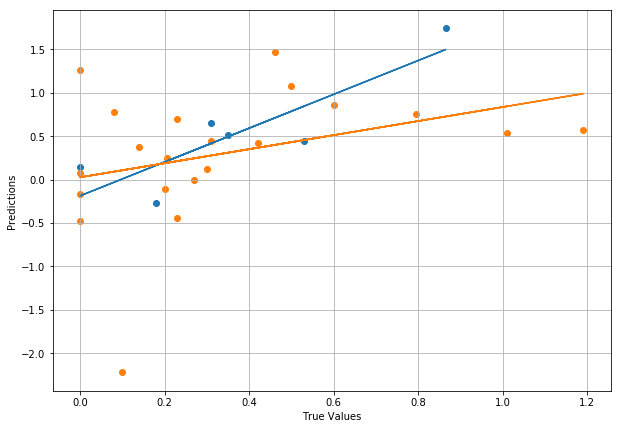

In [952]:
lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)

predictions = lm.predict(X_test)
y_cv = cross_val_predict(lm, X_train, y_train, cv=10)

r2_cv = r2_score(y_train, y_cv)
r2_p = r2_score(y_test, predictions)

rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
rmse = sqrt(mean_squared_error(y_test, predictions))


"""
print("")
print("R2_cv: ",r2_cv)
print("RMSE_cv: ", rmse_cv)
print("R2_pred: ", r2_p)
print("RMSE_pred: ", rmse)
"""

print(r2_cv)
print(rmse_cv)
print(r2_p)
print(rmse)


b=np.append(y_test, predictions, axis=1)

#print("[real, predictions]")
#print(b)
plt.figure(figsize=(10,7))
plt.scatter(y_test, predictions)
plt.scatter(y_train, y_cv)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, predictions).predict(y_test) )
plt.plot( y_train, linear_model.LinearRegression().fit(y_train, y_cv).predict(y_train) )
plt.xlabel('True Values')
#plt.savefig("../basic_Linear.png")
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Elastic Net

In [953]:
alphas = [0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

mses = []

for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    
    y_cv = cross_val_predict(model, X_train, y_train, cv=10)
    mse = mean_squared_error(y_train, y_cv)
    score = model.score(X_train, y_train)
    #pred_y = model.predict(X_test)
    #mse = mean_squared_error(y_test, pred_y)
    mses.append(mse)
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))
    


Alpha:0.0000, R2:1.00, MSE:0.99, RMSE:0.99
Alpha:0.0000, R2:1.00, MSE:0.99, RMSE:0.99
Alpha:0.0000, R2:1.00, MSE:0.85, RMSE:0.92
Alpha:0.0001, R2:1.00, MSE:0.23, RMSE:0.48
Alpha:0.0010, R2:1.00, MSE:0.26, RMSE:0.51
Alpha:0.0100, R2:1.00, MSE:0.26, RMSE:0.51
Alpha:0.1000, R2:1.00, MSE:0.21, RMSE:0.46
Alpha:0.3000, R2:1.00, MSE:0.24, RMSE:0.49
Alpha:0.5000, R2:0.99, MSE:0.24, RMSE:0.49
Alpha:0.7000, R2:0.99, MSE:0.23, RMSE:0.48
Alpha:1.0000, R2:0.99, MSE:0.21, RMSE:0.45


-0.44314080065842276
0.3879339779300894
0.735919618583124
0.14035614089250836


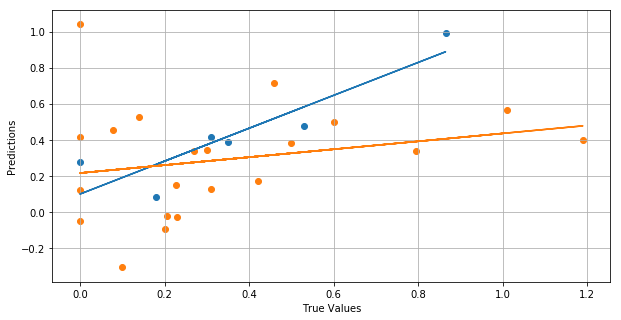

In [954]:
best_index =np.argmin(mses)
model = ElasticNet(alpha=best_index).fit(X_train,y_train)   

y_cv = cross_val_predict(model, X_train, y_train, cv=10)
y_pred = model.predict(X_test)


# Calculate score and error
r2_cv = r2_score(y_train, y_cv)
r2_p = r2_score(y_test, y_pred)

rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
rmse = sqrt(mean_squared_error(y_test, y_pred))


"""
print("")
print("R2_cv: ",r2_cv)
print("RMSE_cv: ", rmse_cv)
print("R2_pred: ", r2_p)
print("RMSE_pred: ", rmse)
"""

print(r2_cv)
print(rmse_cv)
print(r2_p)
print(rmse)

plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_cv)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.plot( y_train, linear_model.LinearRegression().fit(y_train, y_cv).predict(y_train) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
#plt.savefig("../basic_ElasticNet.png")
plt.grid(True)
plt.show()

## Random Forest

In [955]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(6,)
(21,)


0.764897295054039
0.13243176353000333


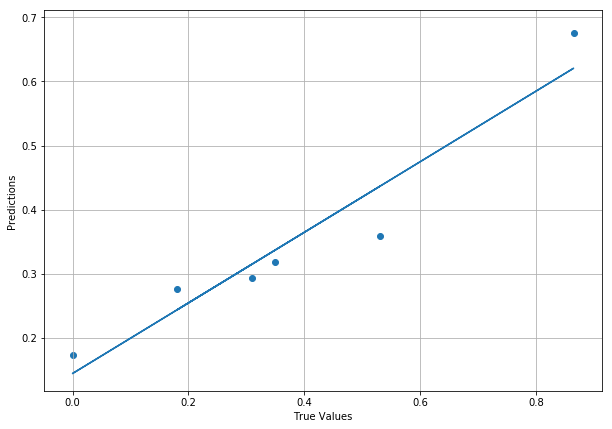

In [956]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, max_depth=30, random_state = 42)
# Train the model on training data

rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
#y_cv = cross_val_predict(rf, X_train, y_train, cv=10)
predictions = rf.predict(X_test)


# Calculate score and error
r2_cv = r2_score(y_train, y_cv)
r2_p = r2_score(y_test, predictions)

rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
rmse = sqrt(mean_squared_error(y_test, predictions))


"""
print("")
print("R2_cv: ",r2_cv)
print("RMSE_cv: ", rmse_cv)
print("R2_pred: ", r2_p)
print("RMSE_pred: ", rmse)
"""

print(r2_p)
print(rmse)


y_test= y_test.reshape((len(y_test), 1))
predictions=predictions.reshape((len(y_test), 1))
y_train= y_train.reshape((len(y_train), 1))
y_cv=y_cv.reshape((len(y_train), 1))
#print((y_test, predictions))

#b=np.append(y_test, predictions, axis=1)

#print("[real, predictions]")
#print(b)

plt.figure(figsize=(10,7))
plt.scatter(y_test, predictions)
#plt.scatter(y_train, y_cv)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, predictions).predict(y_test) )
#plt.plot( y_train, linear_model.LinearRegression().fit(y_train, y_cv).predict(y_train) )
plt.grid(True)
#plt.savefig("../basic_RF.png")
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [957]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)

X_train = StandardScaler().fit_transform(X_train.values)
X_test = StandardScaler().fit_transform(X_test.values)

## SVM

In [958]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.model_selection import learning_curve

### linear SVM

best index:  0
best gamma:  1

-0.653309439688555
0.4152221757629843
0.9106652660370815
0.08163445987819501


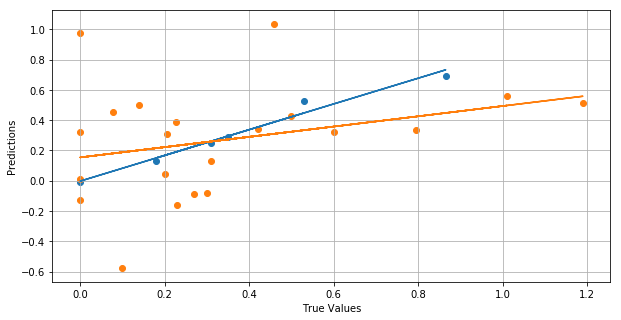

In [959]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) #KFold cross validator

gamma_values = [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001, 0.0001]
accuracy_scores=[]

# Do model selection over all the possible values of gamma
for gamma in gamma_values:
    # Train a classifier with current gamma
    svr = SVR(kernel='linear', gamma=gamma)

    # Compute cross-validated accuracy scores
    scores = cross_val_score(svr, X_train, y_train, cv=kf.split(X_train), scoring = 'r2' )


    accuracy_score = scores.mean()
    accuracy_scores.append(accuracy_score)

# Get the gamma with highest mean accuracy
best_index = np.array(accuracy_scores).argmax()
best_gamma = gamma_values[best_index]
print("best index: ",best_index)
print("best gamma: ", best_gamma)

# Train over the full training set with the best gamma
svr = SVR(C=10, kernel='linear', gamma=best_gamma)
svr.fit(X_train, y_train)

# Evaluate on the test set 
y_pred = svr.predict(X_test)
#cross-val results
y_cv = cross_val_predict(svr, X_train, y_train, cv=10)

# Calculate score and error
r2_cv = r2_score(y_train, y_cv)
r2_p = r2_score(y_test, y_pred)

rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
rmse = sqrt(mean_squared_error(y_test, y_pred))

"""
print("")
print("R2_cv: ",r2_cv)
print("RMSE_cv: ", rmse_cv)
print("R2_pred: ", r2_p)
print("RMSE_pred: ", rmse)
"""
print("")
print(r2_cv)
print(rmse_cv)
print(r2_p)
print(rmse)


plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_cv)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.plot( y_train, linear_model.LinearRegression().fit(y_train, y_cv).predict(y_train) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
#plt.savefig("../basic_svr.png")
plt.grid(True)
plt.show()

### polynomial SVM

best index:  9
best gamma:  0.0001

-0.15764351989540382
0.34744885887131893
0.7569807743894639
0.13464296468992593


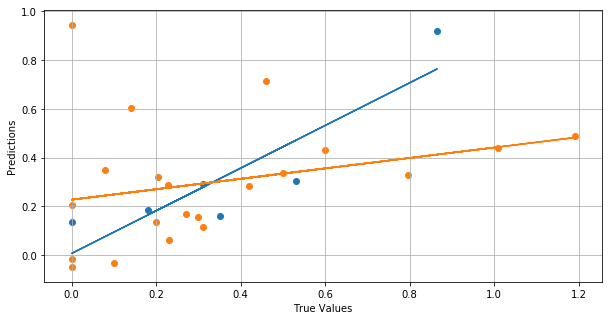

In [960]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) #KFold cross validator

gamma_values = [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001, 0.0001]
accuracy_scores=[]

# Do model selection over all the possible values of gamma
for gamma in gamma_values:
    # Train a classifier with current gamma
    svr = SVR(kernel='poly', degree=2, coef0=1.0, gamma=gamma)

    # Compute cross-validated accuracy scores
    scores = cross_val_score(svr, X_train, y_train, cv=kf.split(X_train), scoring = 'r2' )


    accuracy_score = scores.mean()
    accuracy_scores.append(accuracy_score)

# Get the gamma with highest mean accuracy
best_index = np.array(accuracy_scores).argmax()
best_gamma = gamma_values[best_index]
print("best index: ",best_index)
print("best gamma: ", best_gamma)

# Train over the full training set with the best gamma
svr = SVR(kernel='poly', degree=2, coef0=1.0, gamma=best_gamma)
svr.fit(X_train, y_train)

# Evaluate on the test set 
y_pred = svr.predict(X_test)
#cross-val results
y_cv = cross_val_predict(svr, X_train, y_train, cv=10)

# Calculate score and error
r2_cv = r2_score(y_train, y_cv)
r2_p = r2_score(y_test, y_pred)

rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
rmse = sqrt(mean_squared_error(y_test, y_pred))


"""
print("")
print("R2_cv: ",r2_cv)
print("RMSE_cv: ", rmse_cv)
print("R2_pred: ", r2_p)
print("RMSE_pred: ", rmse)
"""
print("")
print(r2_cv)
print(rmse_cv)
print(r2_p)
print(rmse)


plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_cv)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.plot( y_train, linear_model.LinearRegression().fit(y_train, y_cv).predict(y_train) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
#plt.savefig("../basic_svr.png")
plt.grid(True)
plt.show()

### rbf SVM

best index:  10
best gamma:  1e-05

-0.0423711863881151
0.32969675000465737
0.3973535065311712
0.21202870772432345


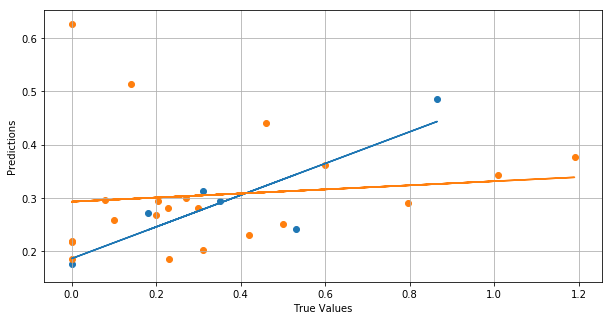

In [961]:


kf = KFold(n_splits=5, shuffle=True, random_state=42) #KFold cross validator

gamma_values = [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001, 0.0001, 0.00001]
accuracy_scores=[]

# Do model selection over all the possible values of gamma
for gamma in gamma_values:
    # Train a classifier with current gamma
    svr = SVR(kernel='rbf', gamma=gamma)

    # Compute cross-validated accuracy scores
    scores = cross_val_score(svr, X_train, y_train, cv=kf.split(X_train), scoring = 'r2' )


    accuracy_score = scores.mean()
    accuracy_scores.append(accuracy_score)

# Get the gamma with highest mean accuracy
best_index = np.array(accuracy_scores).argmax()
best_gamma = gamma_values[best_index]
print("best index: ",best_index)
print("best gamma: ", best_gamma)

# Train over the full training set with the best gamma
svr = SVR(kernel='rbf', gamma=best_gamma)
svr.fit(X_train, y_train)

# Evaluate on the test set 
y_pred = svr.predict(X_test)
#cross-val results
y_cv = cross_val_predict(svr, X_train, y_train, cv=10)

# Calculate score and error
r2_cv = r2_score(y_train, y_cv)
r2_p = r2_score(y_test, y_pred)

rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
rmse = sqrt(mean_squared_error(y_test, y_pred))
"""
print("")
print("R2_cv: ",r2_cv)
print("RMSE_cv: ", rmse_cv)
print("R2_pred: ", r2_p)
print("RMSE_pred: ", rmse)
"""
print("")
print(r2_cv)
print(rmse_cv)
print(r2_p)
print(rmse)

plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_cv)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.plot( y_train, linear_model.LinearRegression().fit(y_train, y_cv).predict(y_train) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
#plt.savefig("../basic_svr.png")
plt.grid(True)
plt.show()